# Technical analysis chart with custom indicators

This is a notebook where we see how to create a candlestick chart with custom indicators. We will define a method which will easily allow us to add indicators (overlapped and not ovelapped).

In [1]:
import pandas as pd
import datetime
import numpy as np
import talib as ta

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker

from matplotlib.finance import candlestick2_ochl
from matplotlib import gridspec

# Smaller font for plotting
matplotlib.rcParams.update({'font.size': 7})

/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The finance module has been deprecated in mpl 2.0 and will be removed in mpl 2.2. Please use the module mpl_finance instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [10]:
%matplotlib notebook

## Dataframe standardization

We have to standardize the dataframe in order to pass the standard dataframe to the chart method.

The standard dataframe will have the following columns:

* Date (index)
* Open
* High
* Close
* Low
* Volume

I downloaded the historical data from the following web page: https://www.kaggle.com/mczielinski/bitcoin-historical-data/data

In [5]:
def datetime_parse_timestamp (time_in_secs):    
    return datetime.datetime.fromtimestamp(float(time_in_secs))

def create_std_df (date, open, high, close, low, volume):
    df = pd.DataFrame()
    df['Date'] = date
    df['Open'] = open
    df['High'] = high
    df['Close'] = close
    df['Low'] = low
    df['Volume'] = volume
    
    # Create the date index
    df.set_index(keys=['Date'], inplace=True)
    
    # Cleaning data
    df['Volume'].fillna(value = 0, inplace = True)
    df.fillna(method="ffill", inplace = True)
    df.fillna(method="bfill", inplace = True)
    
    return df

df = pd.read_csv('/home/jovyan/work/data/bitstampUSD_1-min_data_2012-01-01_to_2017-05-31.csv', parse_dates=True, date_parser=datetime_parse_timestamp, index_col='Timestamp')
    
df_std = create_std_df(df.index.values, df['Open'].values, df['High'].values, df['Close'].values, df['Low'].values, df['Volume_(BTC)'].values + df['Volume_(Currency)'].values)
df_std.tail()

,Open,High,Close,Low,Volume
Date,,,,,
2017-05-30 23:56:00,2190.49,2190.49,2181.37,2181.37,3725.484921
2017-05-30 23:57:00,2190.50,2197.52,2195.63,2186.17,14409.372990
2017-05-30 23:58:00,2195.62,2197.52,2191.83,2191.52,34376.686494
2017-05-30 23:59:00,2195.82,2216.00,2203.51,2195.82,59940.582874
2017-05-31 00:00:00,2201.70,2209.81,2208.33,2196.98,21982.270790


## Defining the utility classes

We define the utility classes for passing them to the main method usinf for charting

In [6]:
class TechnicalIndicator:
     def __init__(self, name :str, data, overlap = False, plot_instructions = None):
        self.name = name
        self.overlap = overlap
        self.data = data
        self.plot_instructions = plot_instructions

class Pattern:
    def __init__(self, name :str, data, symbol_up = '^', symbol_down = 'v', plot_instructions = None):
        self.name = name
        # Markers can be found here: https://matplotlib.org/api/markers_api.html
        self.symbol_up = symbol_up
        self.symbol_down = symbol_down
        self.data = data
        self.plot_instructions = plot_instructions

## Plotting function

The plotting function will receive as params:

* ohclv: the Standardized data frame we build previously
* technical_indicators: list of technical indicators object
* patterns: list of patters

In [7]:
def chart (ohclv, technical_indicators=[], patterns=[]):
    
    #Separating technical indicators
    overlapped_technical_indicators = []
    not_overlapped_technical_indicators = []
    
    for ti in technical_indicators:
        if ti.overlap:
            overlapped_technical_indicators.append(ti)
        else: 
            not_overlapped_technical_indicators.append(ti)
            
    ratio = [3]
    for i in range(len(not_overlapped_technical_indicators)):
        ratio.append(1)
    fig, axs = plt.subplots(nrows=1+len(not_overlapped_technical_indicators), ncols=1, sharex=True,
                               gridspec_kw={'height_ratios': ratio}, squeeze=False)
    
    
    date = ohclv.index
    open = ohclv.Open
    close = ohclv.Close
    high = ohclv.High
    low = ohclv.Low
    volume = ohclv.Volume
    
    candlestick2_ochl(ax=axs[0][0], opens=open, highs=high, lows= low, closes=close, width=0.6, colorup='k', colordown='r', alpha=0.75)
    
    for indicator in overlapped_technical_indicators:
        if (indicator.plot_instructions == None):
            axs[0][0].plot(indicator.data, label = indicator.name)
        else:
            indicator.plot_instructions(indicator, axs[0][0])
        

    for pattern in patterns:
        element_index_top = np.where(pattern.data > 0)[0]
        if len(element_index_top) > 0: 
            y_top = np.take(high.values, element_index_top)
            y_top_increment = y_top + (y_top * 0.01)
            axs[0][0].plot(element_index_top, y_top_increment, pattern.symbol_up, label=pattern.name)
        
        element_index_bottom = np.where(pattern.data < 0)[0]
        if len(element_index_bottom) > 0: 
            y_bottom = np.take(high.values, element_index_bottom)
            y_bottom_decrement = y_bottom - (y_bottom * 0.01)
            axs[0][0].plot(element_index_bottom, y_bottom_decrement, pattern.symbol_down, label=pattern.name)    
    axs[0][0].legend()
    axs[0][0].set_ylabel("Pricing information")
    axs[0][0].set_xlim(left=0, right=len(close))
    
    # Plotting Volume
    axv = axs[0][0].twinx()
    axv.fill_between(np.arange(len(volume)), 0, volume.values, alpha=.4)
    axv.axes.yaxis.set_ticklabels([])
    axv.grid(False)
    ###Edit this to 3, so it's a bit larger
    axv.set_ylim(0, 3*volume.max())
    axv.spines['bottom'].set_color("#5998ff")
    axv.spines['top'].set_color("#5998ff")
    axv.spines['left'].set_color("#5998ff")
    axv.spines['right'].set_color("#5998ff")
    axv.tick_params(axis='x', colors='w')
    axv.tick_params(axis='y', colors='w')
    
    
    for i, indicator in enumerate(not_overlapped_technical_indicators):
        #indicator = not_overlapped_technical_indicators[i]
        if (indicator.plot_instructions == None):
            axs[i+1][0].plot(indicator.data, label = indicator.name)
        else:
            indicator.plot_instructions(indicator, axs[i+1][0])
        axs[i+1][0].legend()
        axs[i+1][0].set_ylabel(indicator.name)
    
    
    #xdate = [datetime.datetime.fromtimestamp(i) for i in quotes['time']]
    axs[0][0].xaxis.set_major_locator(mticker.MaxNLocator(10))
    
    def mydate(x,pos):
        try:
            return date[int(x)]
        except IndexError:
            return ''

    axs[0][0].xaxis.set_major_formatter(mticker.FuncFormatter(mydate))
    
    fig.autofmt_xdate()
    fig.tight_layout()    
    fig.subplots_adjust(hspace=0,right=0.99, left=0.1)

    
    plt.show()

## How to use chart function

Here we see how to use the chart method that helps us to print the technical indicators

In [8]:
def plot_bb(ti, ax):
    ax.plot(ti.data[1])
    ax.fill_between(np.arange(len(ti.data[0])),ti.data[0], ti.data[2], interpolate=True, alpha=.1, label="Bollinger Band")

def plot_rsi(ti, ax):
    ax.plot(ti.data, label="RSI")
    ax.fill_between(np.arange(len(ti.data)),30, 0, alpha=.1, color='b')
    ax.fill_between(np.arange(len(ti.data)),70, 100, alpha=.1, color='b')

def plot_macd(ti, ax):
    ax.plot(ti.data[0], label="Fast")
    ax.plot(ti.data[1], label="Slow")
    ax.fill_between(np.arange(len(ti.data[2])),ti.data[2], 0, alpha=.5, label="Macd conv/div")

def plot_stoch(ti, ax):
    ax.plot(ti.data[0], label="Slow K")
    ax.plot(ti.data[1], label="Slow D")
    ax.fill_between(np.arange(len(ti.data[0])),ti.data[0], ti.data[1], alpha=.3)
    
small_set = df_std[-110:]

SMA = ta.SMA(small_set.Close.values, timeperiod=20)
SMA_plot = TechnicalIndicator("SMA", SMA, True)

SMA2 = ta.SMA(small_set.Close.values, timeperiod=50)
SMA2_plot = TechnicalIndicator("SMA2", SMA2, True)

SMA3 = ta.SMA(small_set.Close.values, timeperiod=100)
SMA3_plot = TechnicalIndicator("SMA3", SMA3, True)

BB = ta.BBANDS(small_set.Close.values, timeperiod=20)
BB_plot = TechnicalIndicator("BB", BB, True, plot_bb)

RSI = ta.RSI(small_set.Close.values, timeperiod=14)
RSI_plot = TechnicalIndicator("RSI", RSI, False, plot_rsi)

MACD = ta.MACD(small_set.Close.values,fastperiod=10, slowperiod=20)
MACD_plot = TechnicalIndicator("MACD", MACD, False, plot_macd)

STOCH = ta.STOCH(small_set.High.values, small_set.Low.values, small_set.Close.values)
STOCH_plot = TechnicalIndicator("Stochastic", STOCH, False, plot_stoch)

HAMMER = ta.CDLENGULFING(small_set.Open.values, small_set.High.values, small_set.Low.values, small_set.Close.values)
HAMMER_plot = Pattern("Hammer", HAMMER)

<IPython.core.display.Javascript object>


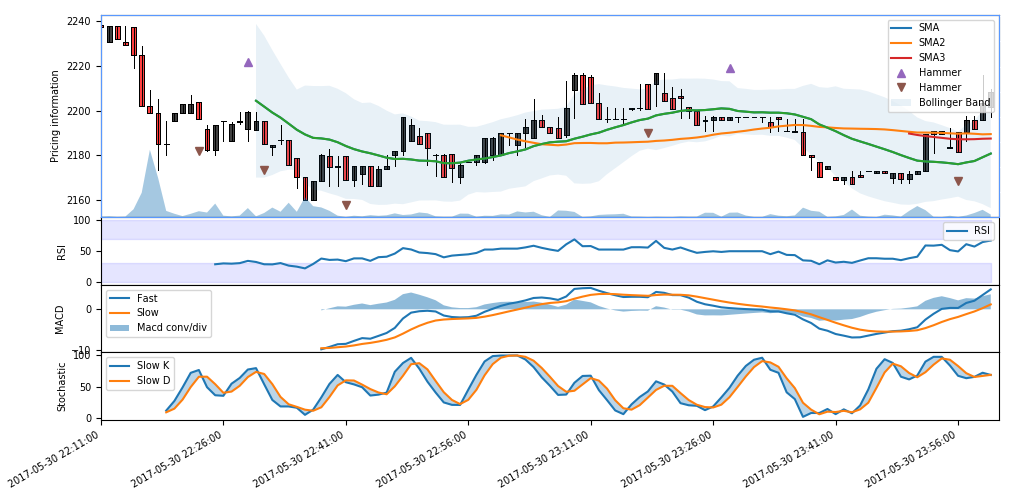

In [11]:
technical_indicators=[SMA_plot, SMA2_plot, BB_plot, SMA3_plot, RSI_plot, MACD_plot, STOCH_plot]
patterns=[HAMMER_plot]
chart(small_set, technical_indicators, patterns=patterns)